In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import PowerTransformer

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [30]:
df = pd.read_csv('Country-data.csv')

In [32]:
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [36]:
df.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

# Check distribution and outlier

In [39]:
def All_plot(X):
    col = X.columns
    for column in col:
        if np.issubdtype(X[column].dtype, np.number):  # Check if the column is numeric
            fig, axes = plt.subplots(1, 3, figsize=(21, 6))  # 3 plots in a row
            
            skewness = X[column].skew()
            
            # Determine skewness type
            if skewness > 0:
                skew_type = "Positive Skewness"
            elif skewness < 0:
                skew_type = "Negative Skewness"
            else:
                skew_type = "Approximately Symmetrical"
            
            print(f"{column}: Skewness = {skewness:.2f} ({skew_type})")
            
            # KDE plot
            sns.kdeplot(X[column].dropna(), fill=True, color='blue', alpha=0.5, ax=axes[0])
            axes[0].set_title(f"KDE Plot for {column}\n(Skewness: {skewness:.2f}) ({skew_type})", fontsize=12)
            axes[0].set_xlabel(column)
            axes[0].set_ylabel('Density')
            axes[0].grid(alpha=0.3)
        
            # Q-Q plot
            stats.probplot(X[column].dropna(), dist="norm", plot=axes[1])
            axes[1].set_title(f"Q-Q Plot for {column}", fontsize=12)
            
            # Boxplot
            sns.boxplot(x=X[column], ax=axes[2])
            axes[2].set_title(f"Boxplot for {column}", fontsize=12)
            axes[2].set_xlabel(column)
            
            plt.tight_layout()
            plt.show()

child_mort: Skewness = 1.45 (Positive Skewness)


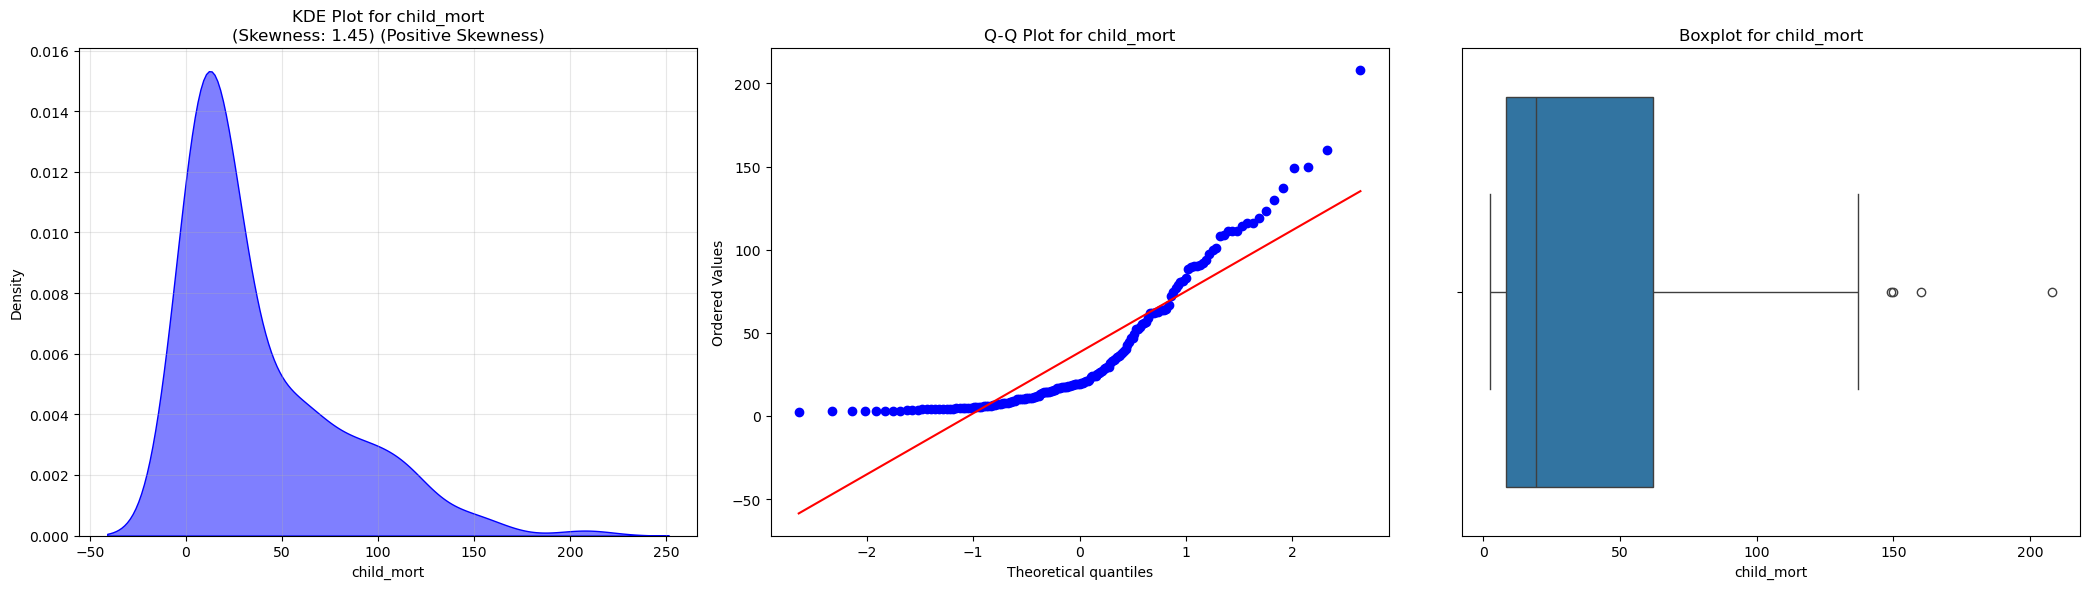

exports: Skewness = 2.45 (Positive Skewness)


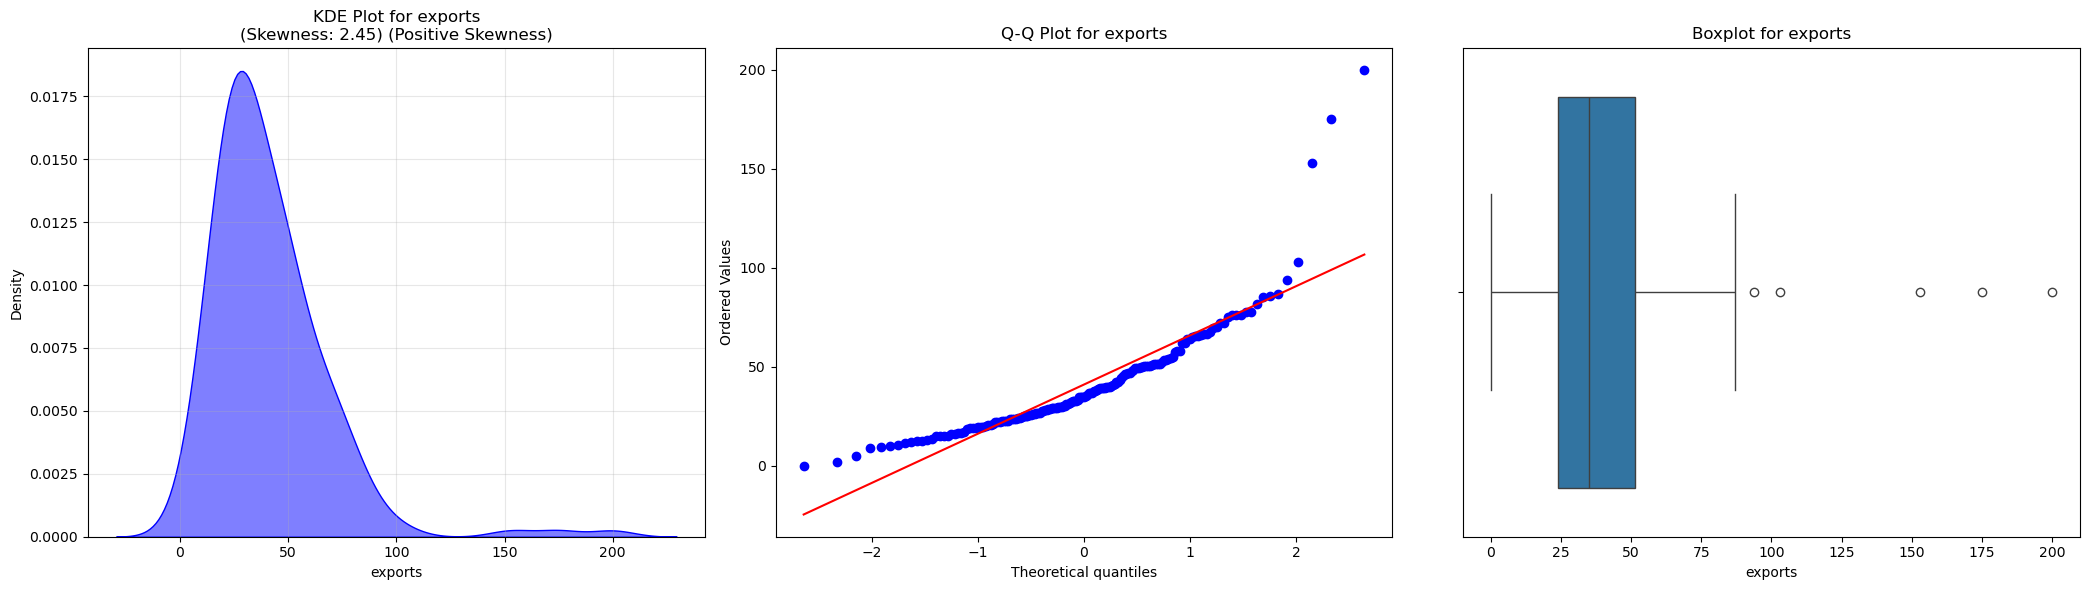

health: Skewness = 0.71 (Positive Skewness)


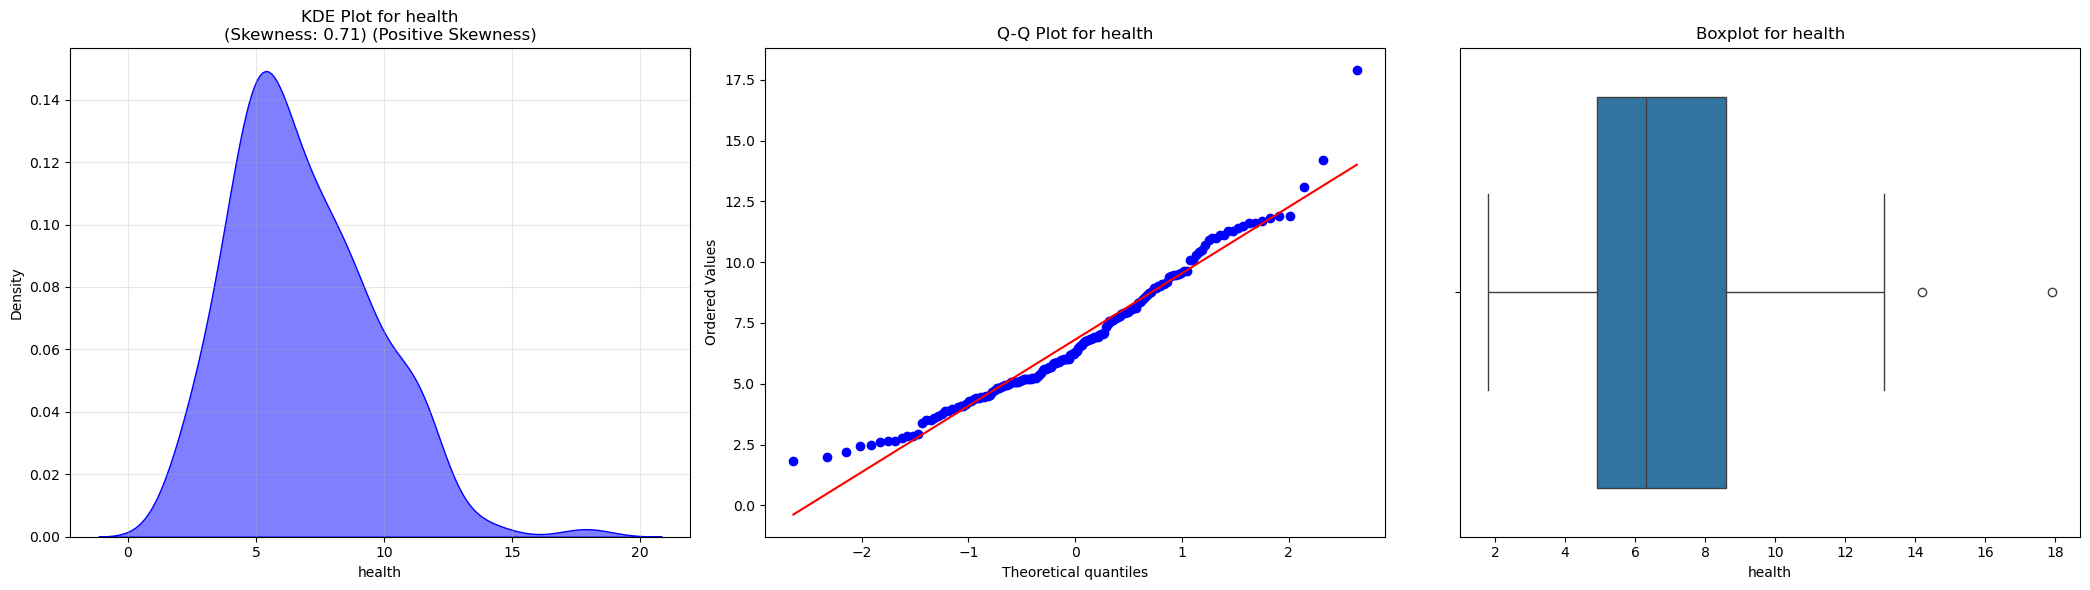

imports: Skewness = 1.91 (Positive Skewness)


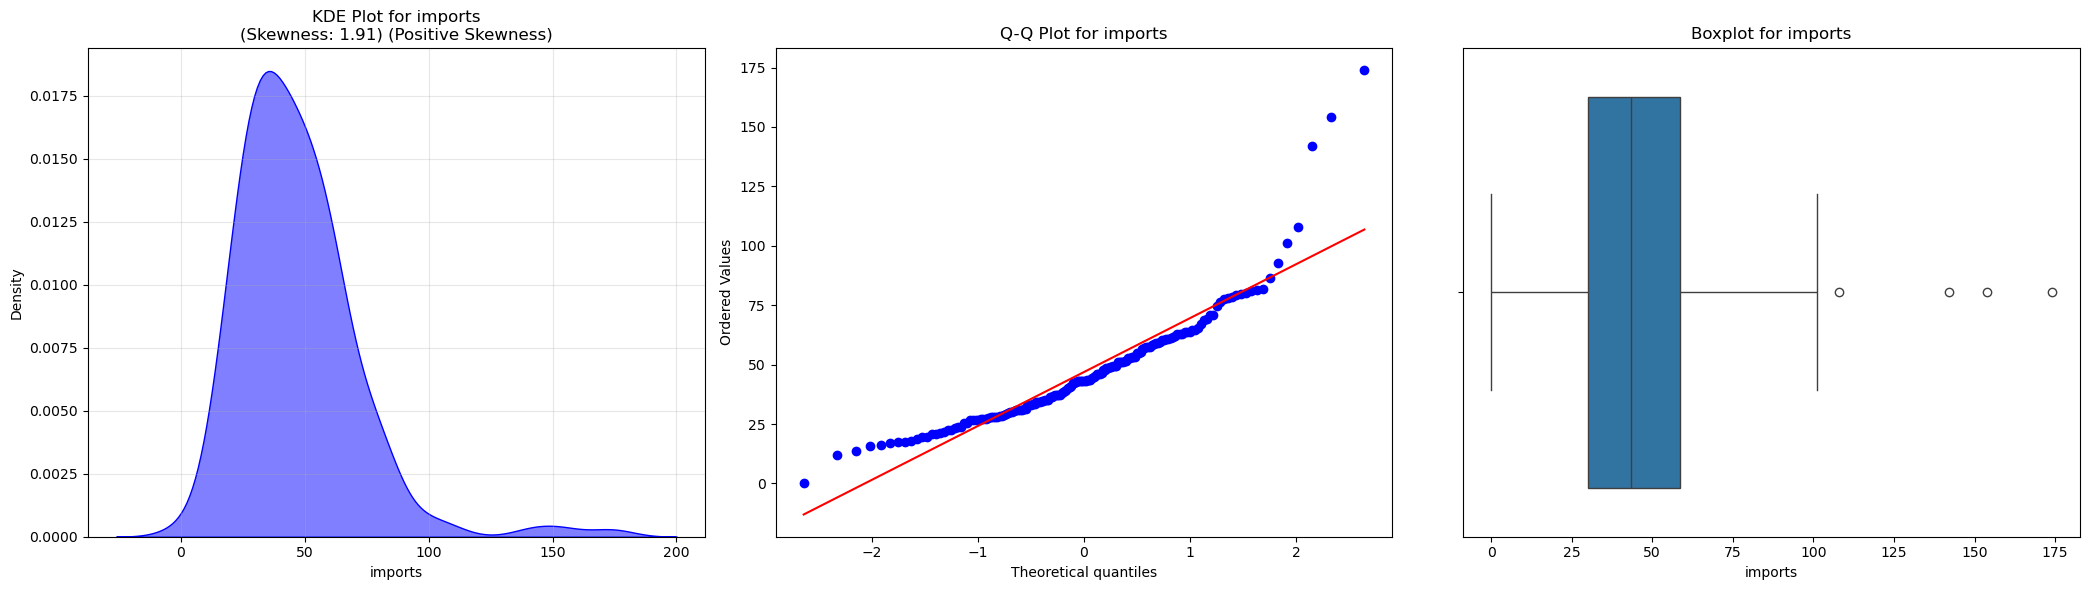

income: Skewness = 2.23 (Positive Skewness)


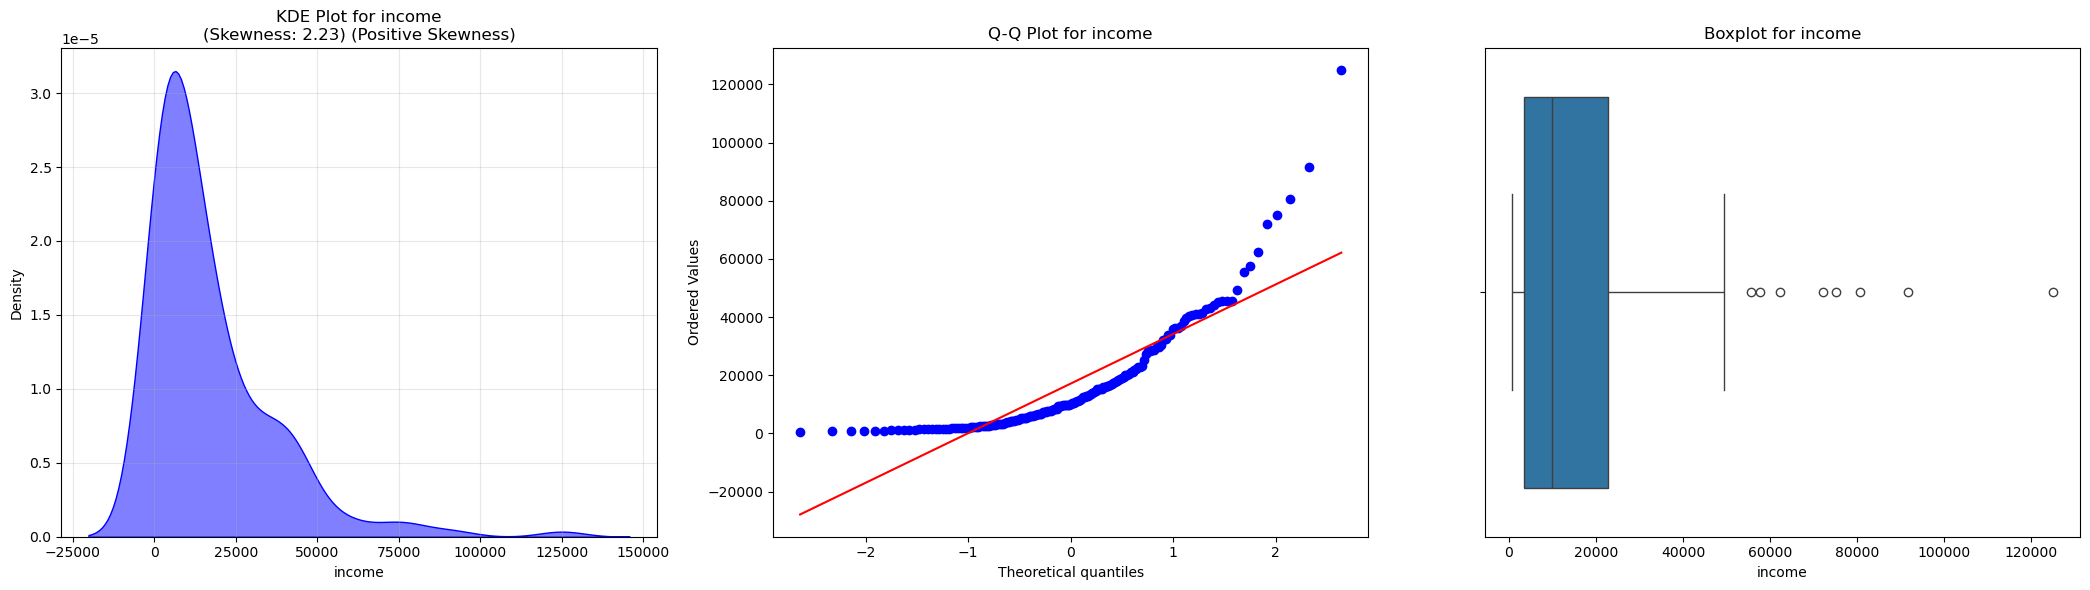

inflation: Skewness = 5.15 (Positive Skewness)


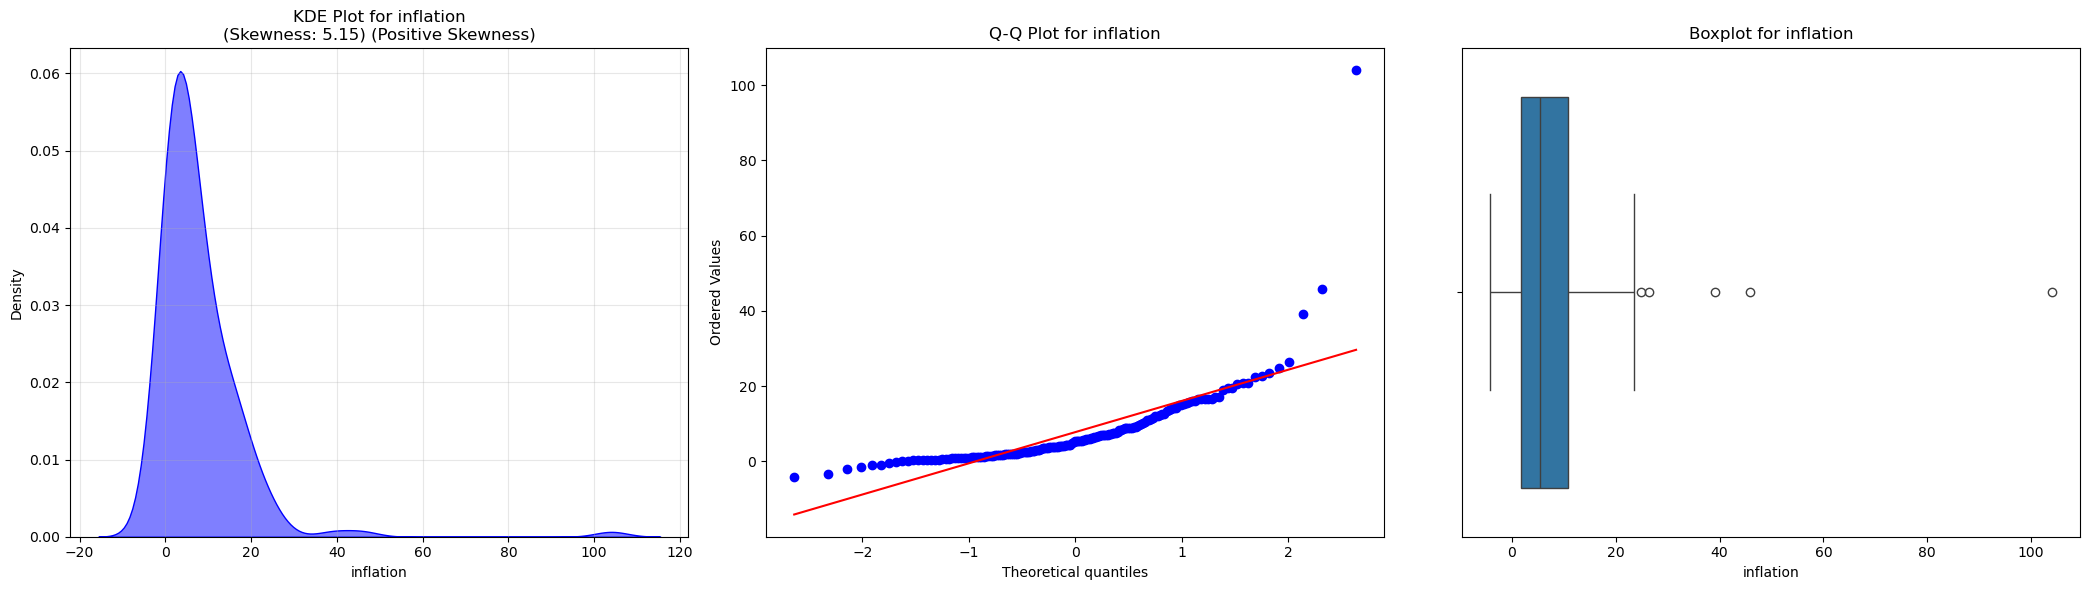

life_expec: Skewness = -0.97 (Negative Skewness)


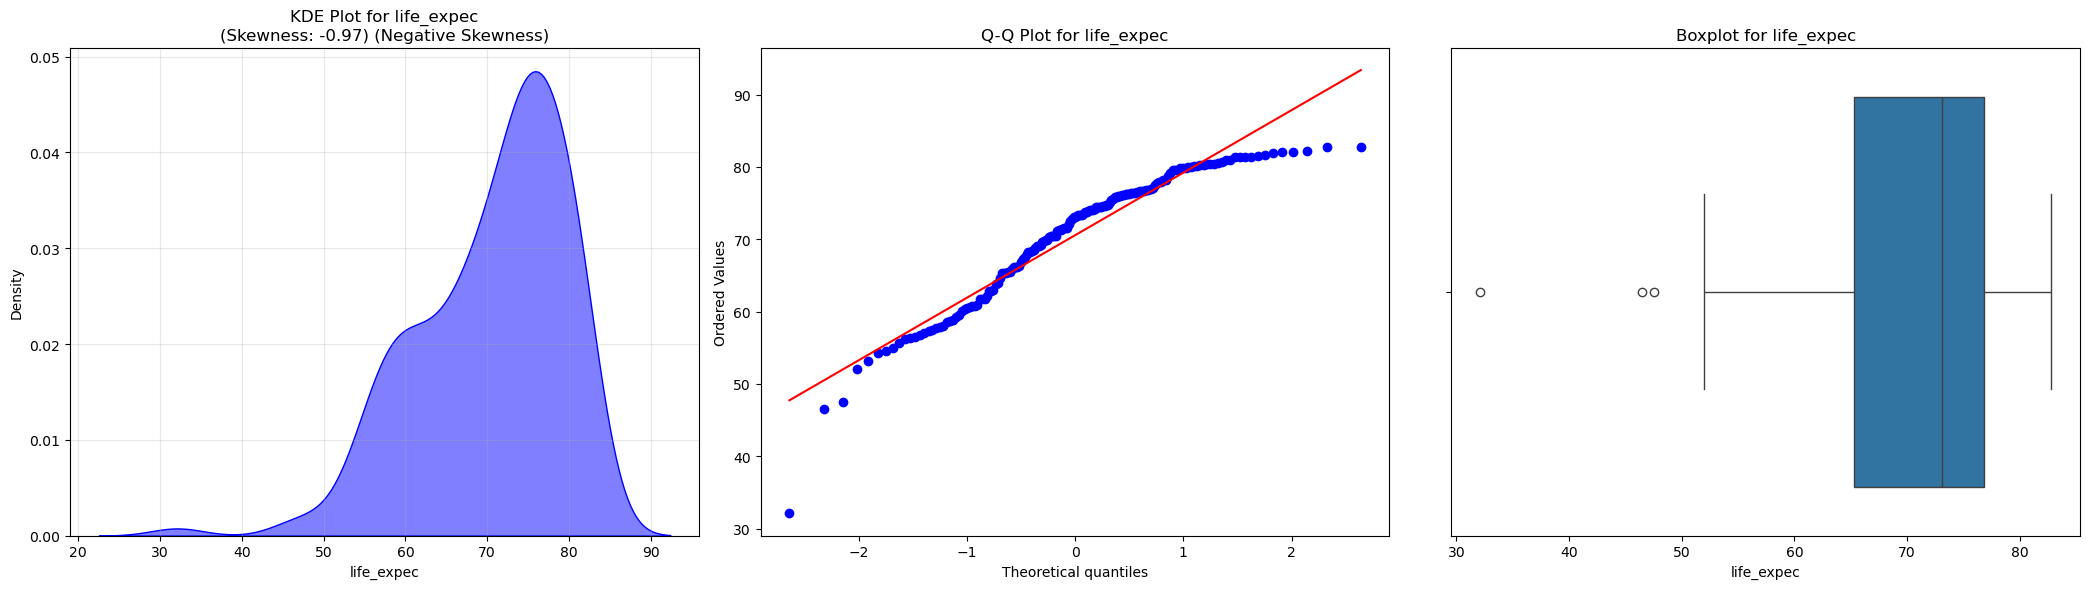

total_fer: Skewness = 0.97 (Positive Skewness)


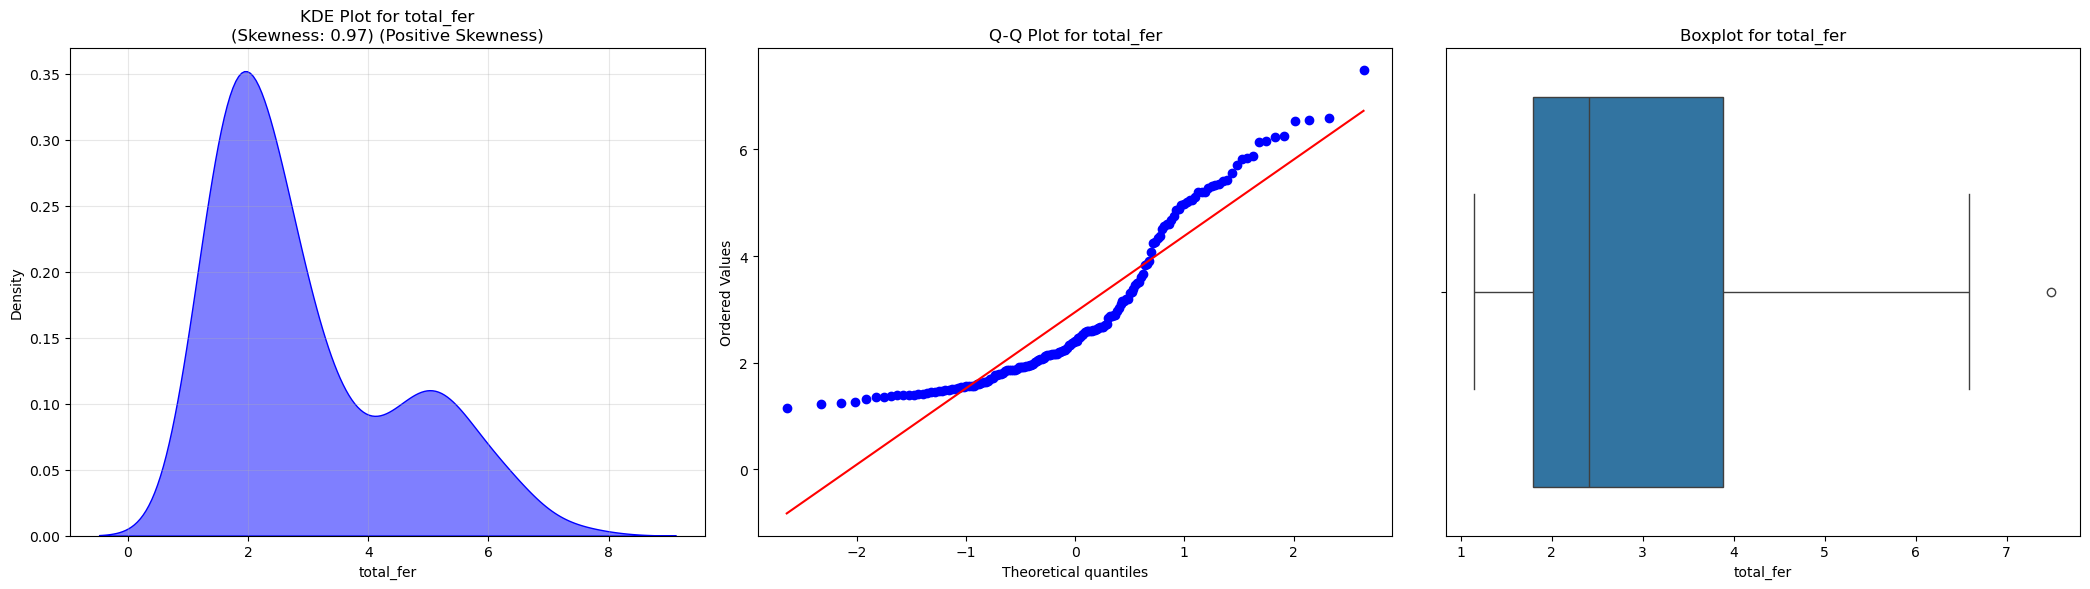

gdpp: Skewness = 2.22 (Positive Skewness)


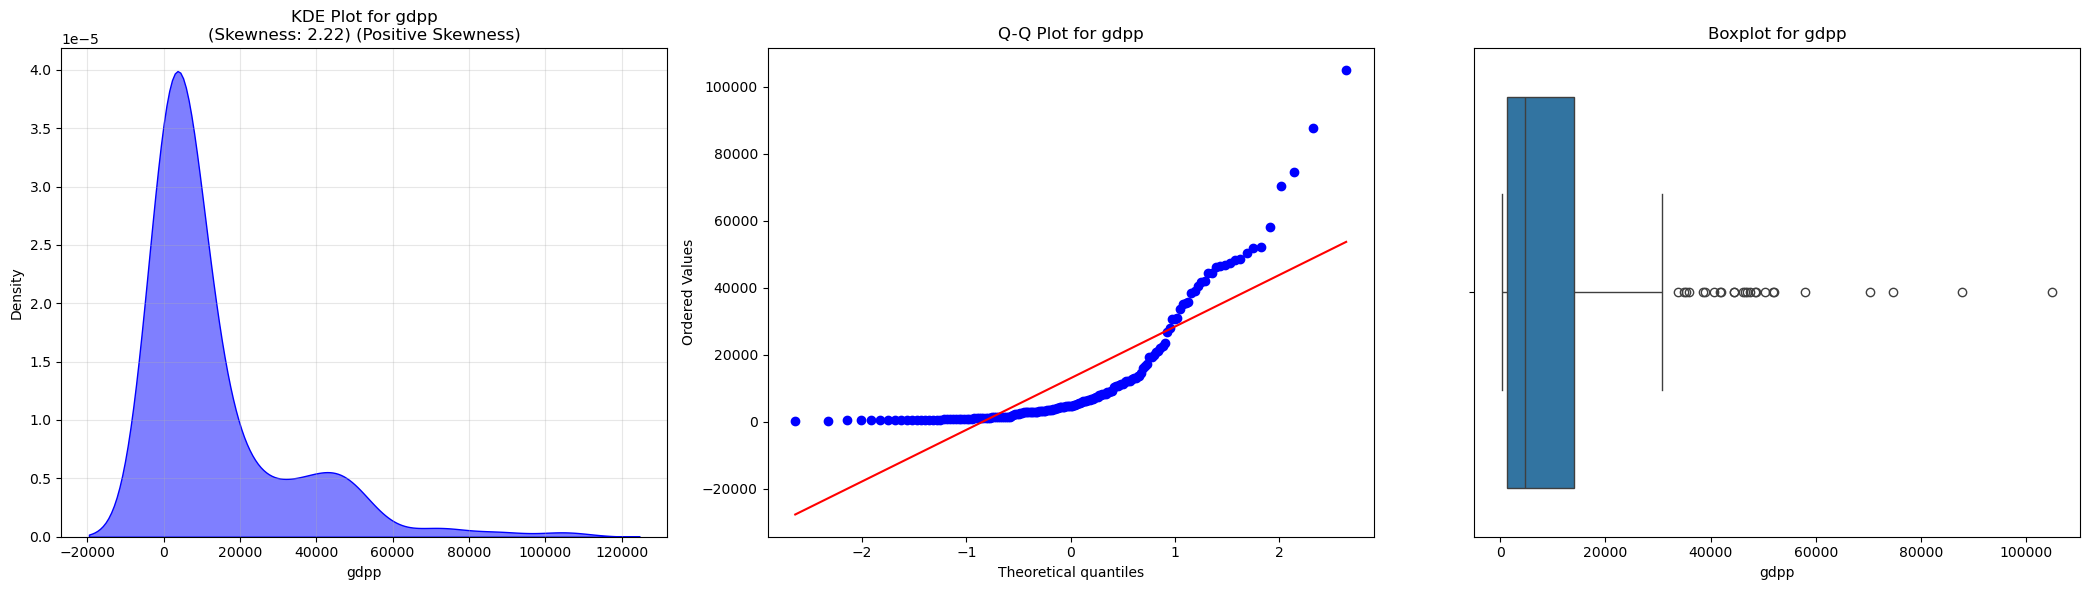

In [41]:
All_plot(df)

In [42]:
X = df.drop(columns='country')

In [43]:
pt = PowerTransformer(standardize=False)
X_tr = pt.fit_transform(X)
X_trd = pd.DataFrame(X_tr,index=X.index,columns=X.columns)
pd.DataFrame({'cols':X.columns,'box_cox_lambdas':pt.lambdas_})

,cols,box_cox_lambdas
0,child_mort,-0.036949
1,exports,0.276790
2,health,0.239192
3,imports,0.364095
4,income,0.097833
5,inflation,0.427835
6,life_expec,3.763292
7,total_fer,-0.943024
8,gdpp,-0.002313


In [55]:
# Function to cap outliers using IQR
def cap_outliers_iqr(df):
    df_capped = df.copy()  # Make a copy to avoid modifying the original DataFrame

    # Loop through numeric columns and cap outliers based on IQR
    for column in df_capped.select_dtypes(include=[np.number]).columns:
        Q1 = df_capped[column].quantile(0.25)
        Q3 = df_capped[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Cap values outside the bounds to the lower or upper bound
        df_capped[column] = np.clip(df_capped[column], lower_bound, upper_bound)

    return df_capped

In [59]:
X_new = cap_outliers_iqr(X_trd)

child_mort: Skewness = 0.02 (Positive Skewness)


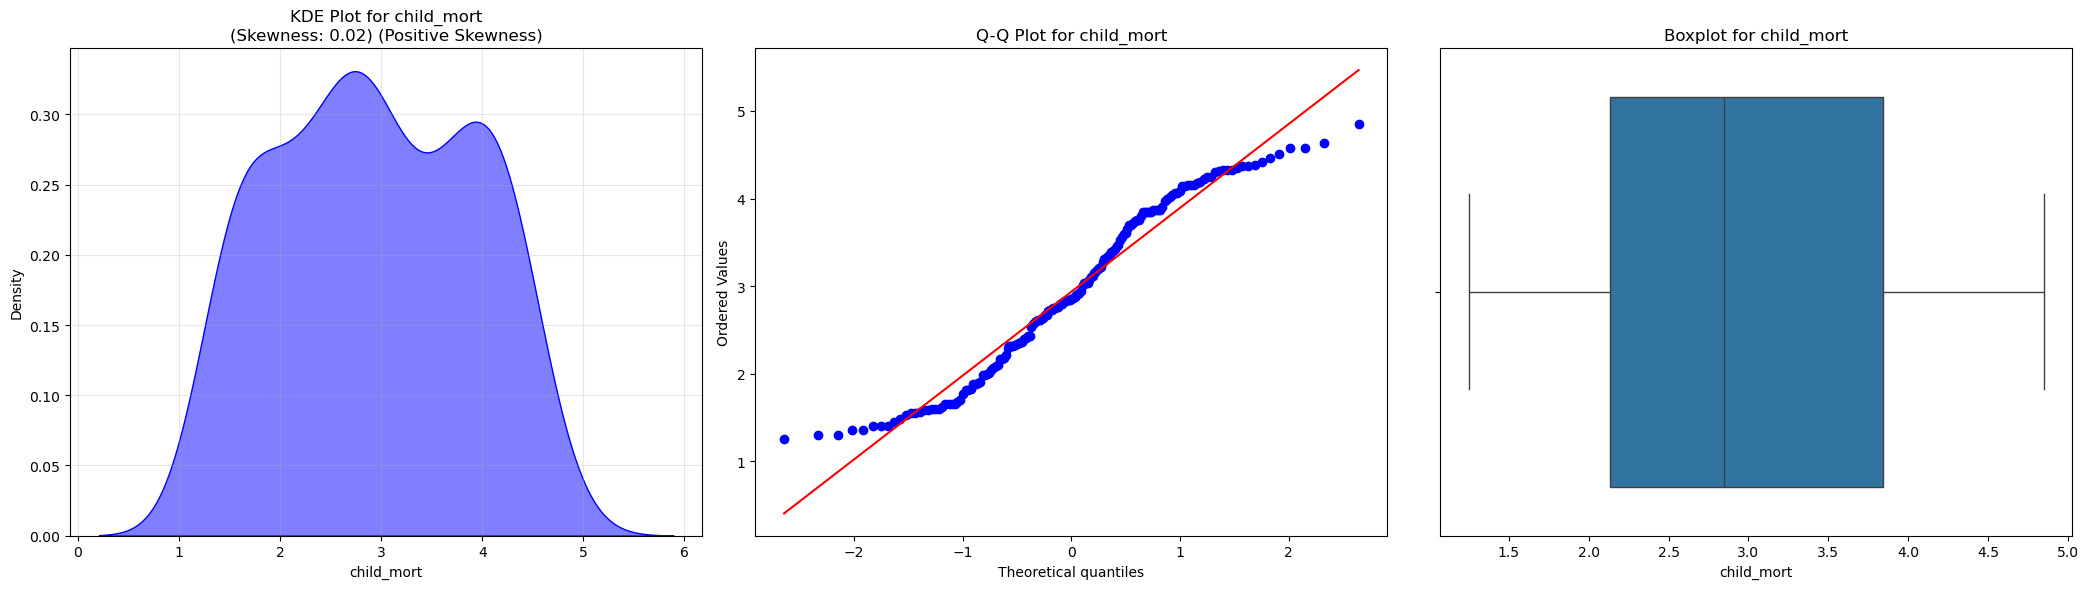

exports: Skewness = 0.04 (Positive Skewness)


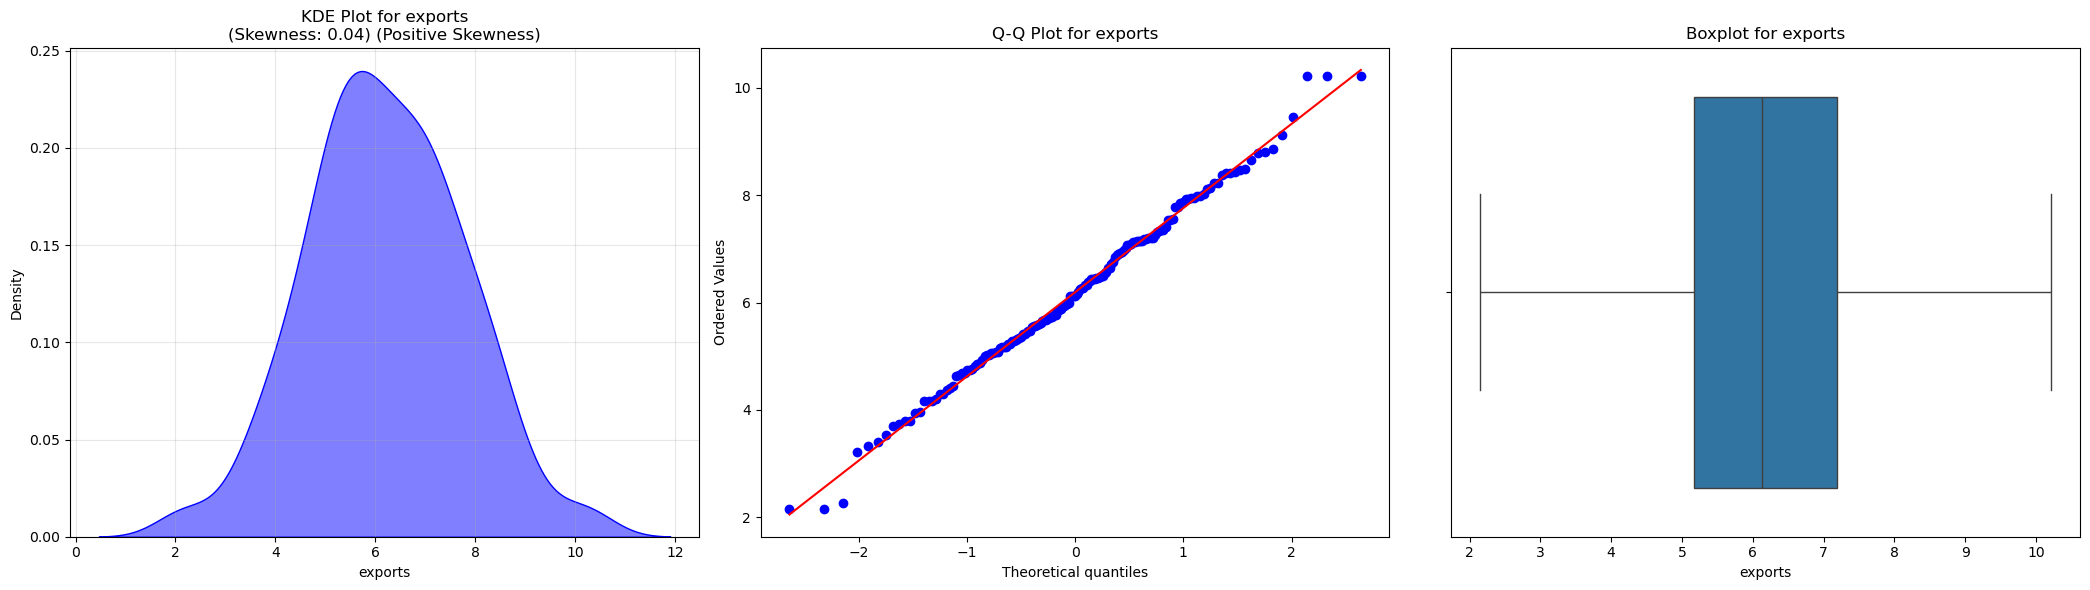

health: Skewness = -0.03 (Negative Skewness)


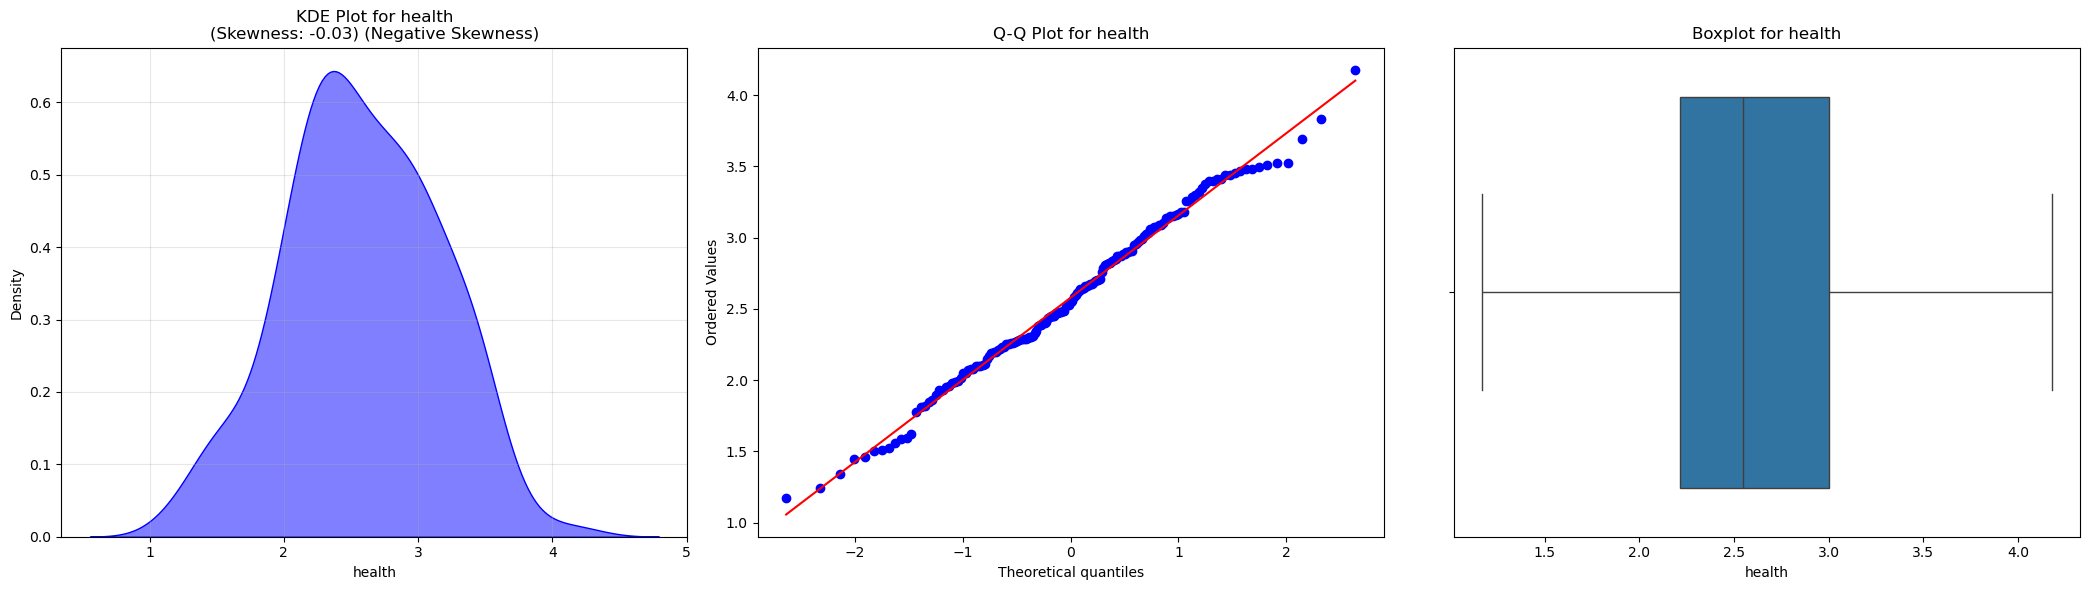

imports: Skewness = 0.21 (Positive Skewness)


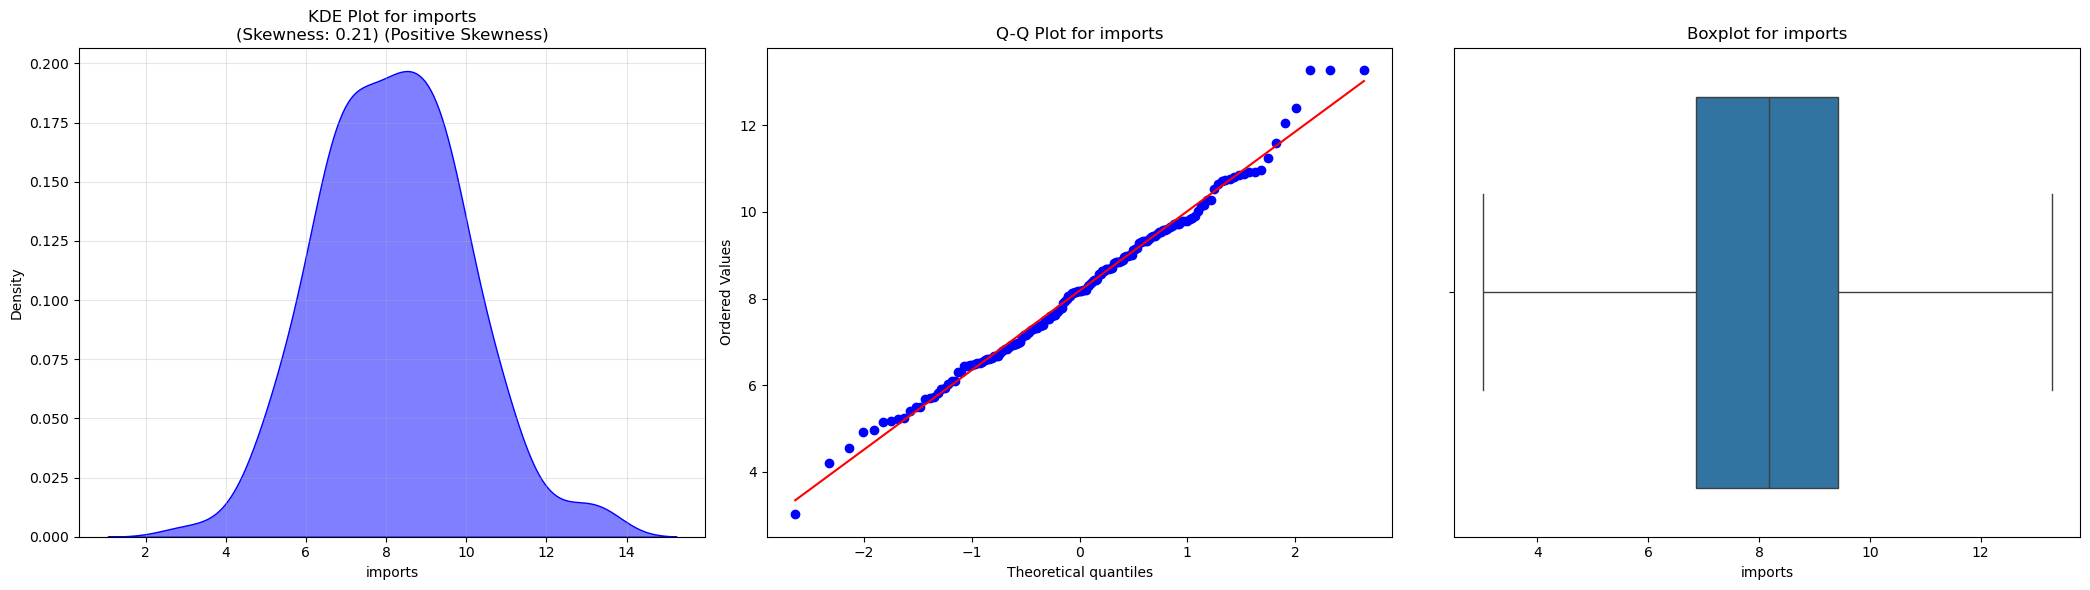

income: Skewness = -0.04 (Negative Skewness)


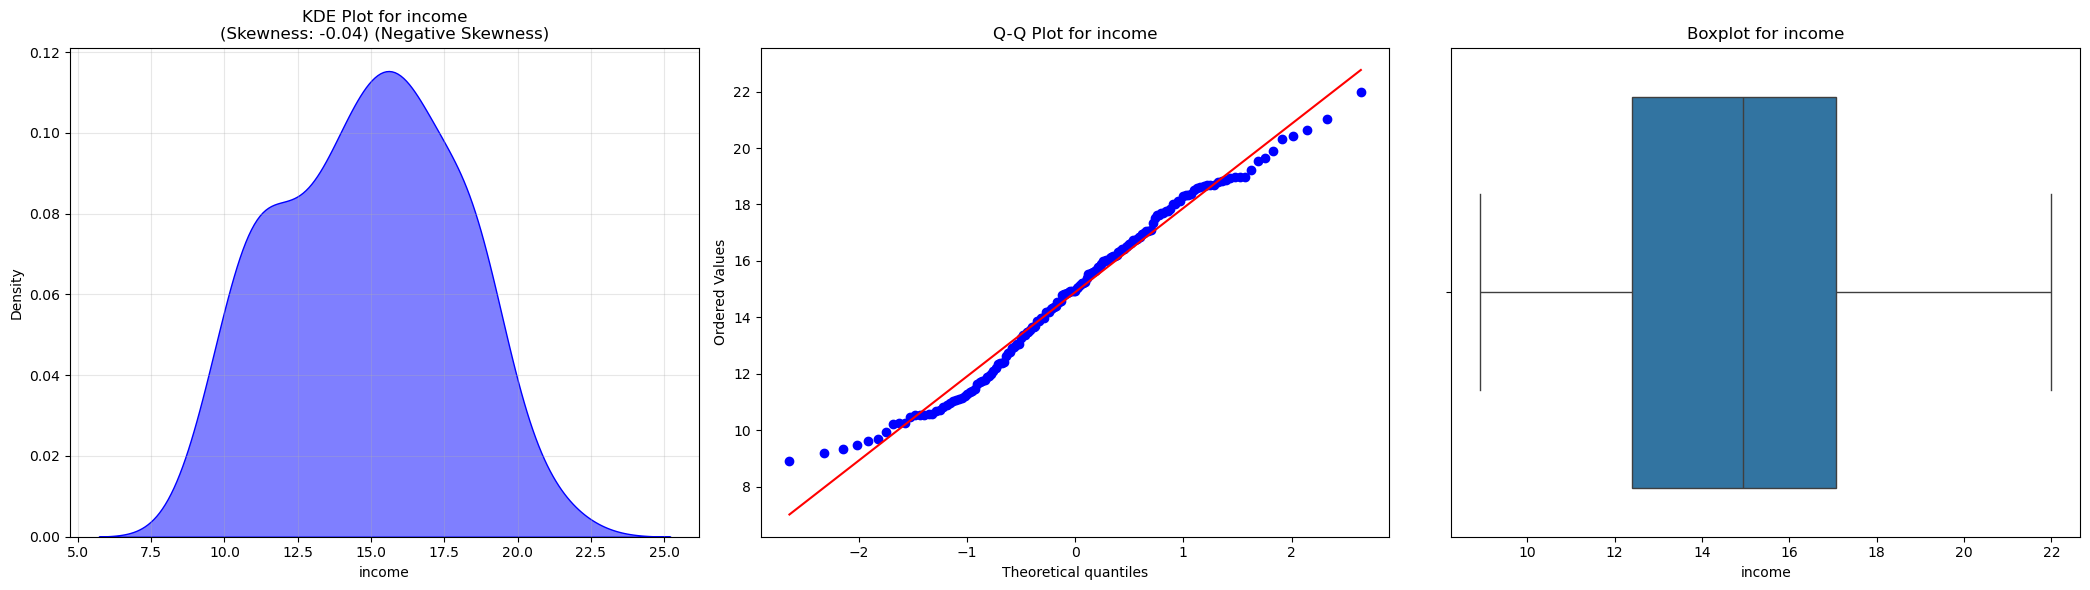

inflation: Skewness = 0.15 (Positive Skewness)


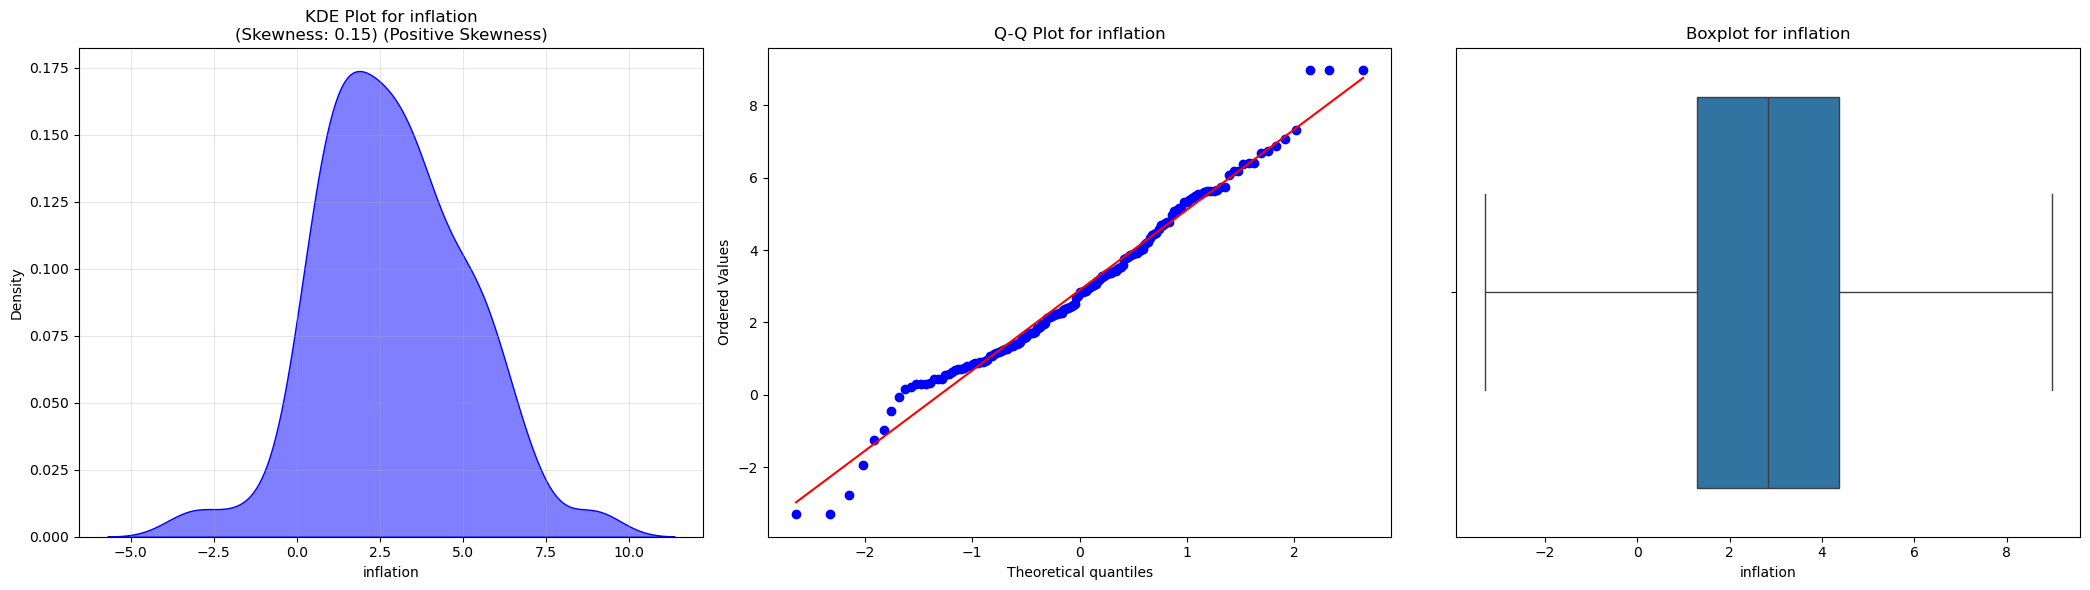

life_expec: Skewness = -0.18 (Negative Skewness)


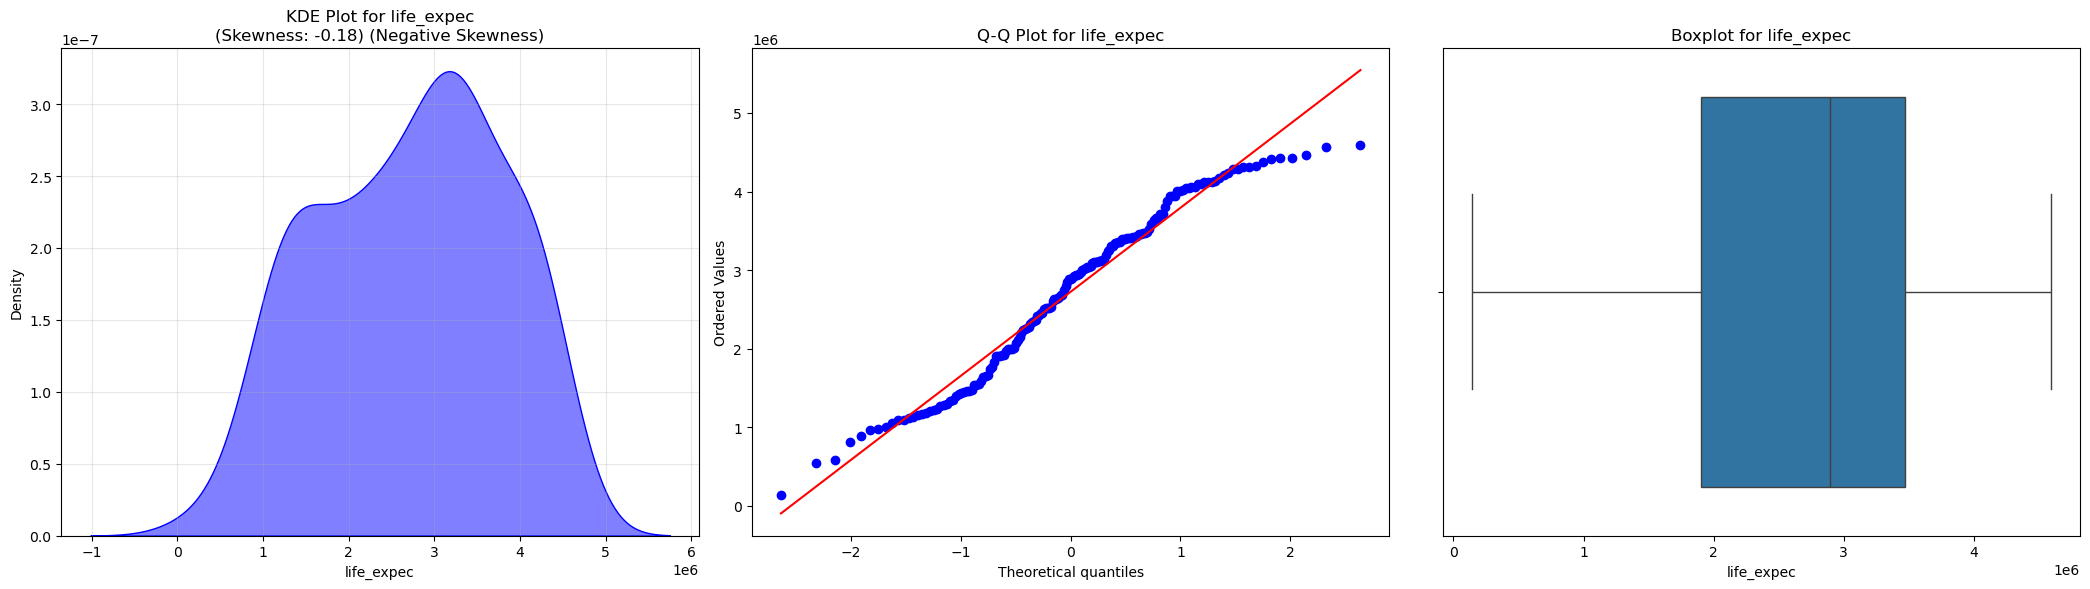

total_fer: Skewness = 0.14 (Positive Skewness)


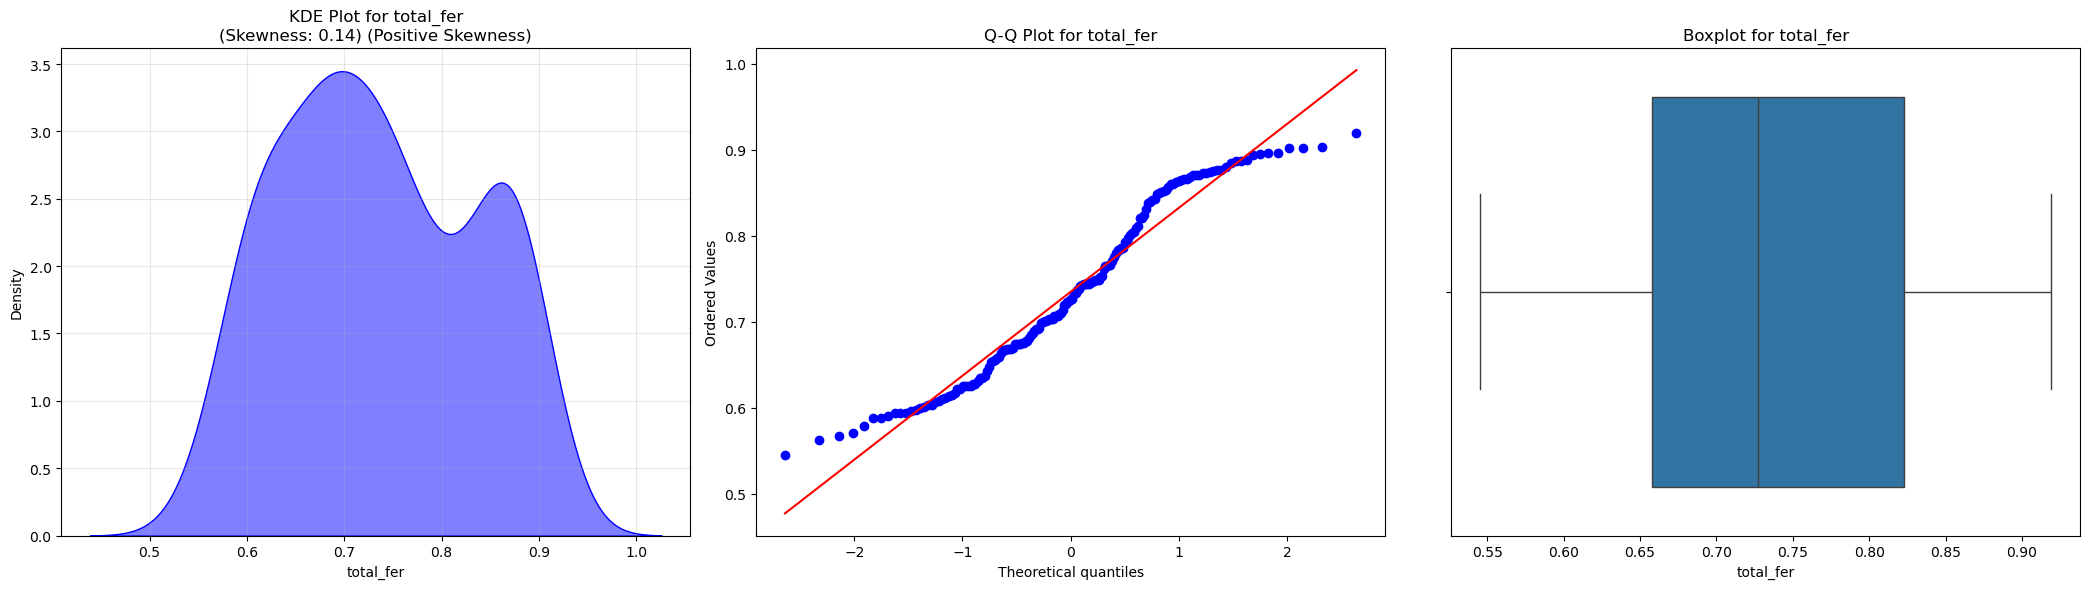

gdpp: Skewness = 0.00 (Positive Skewness)


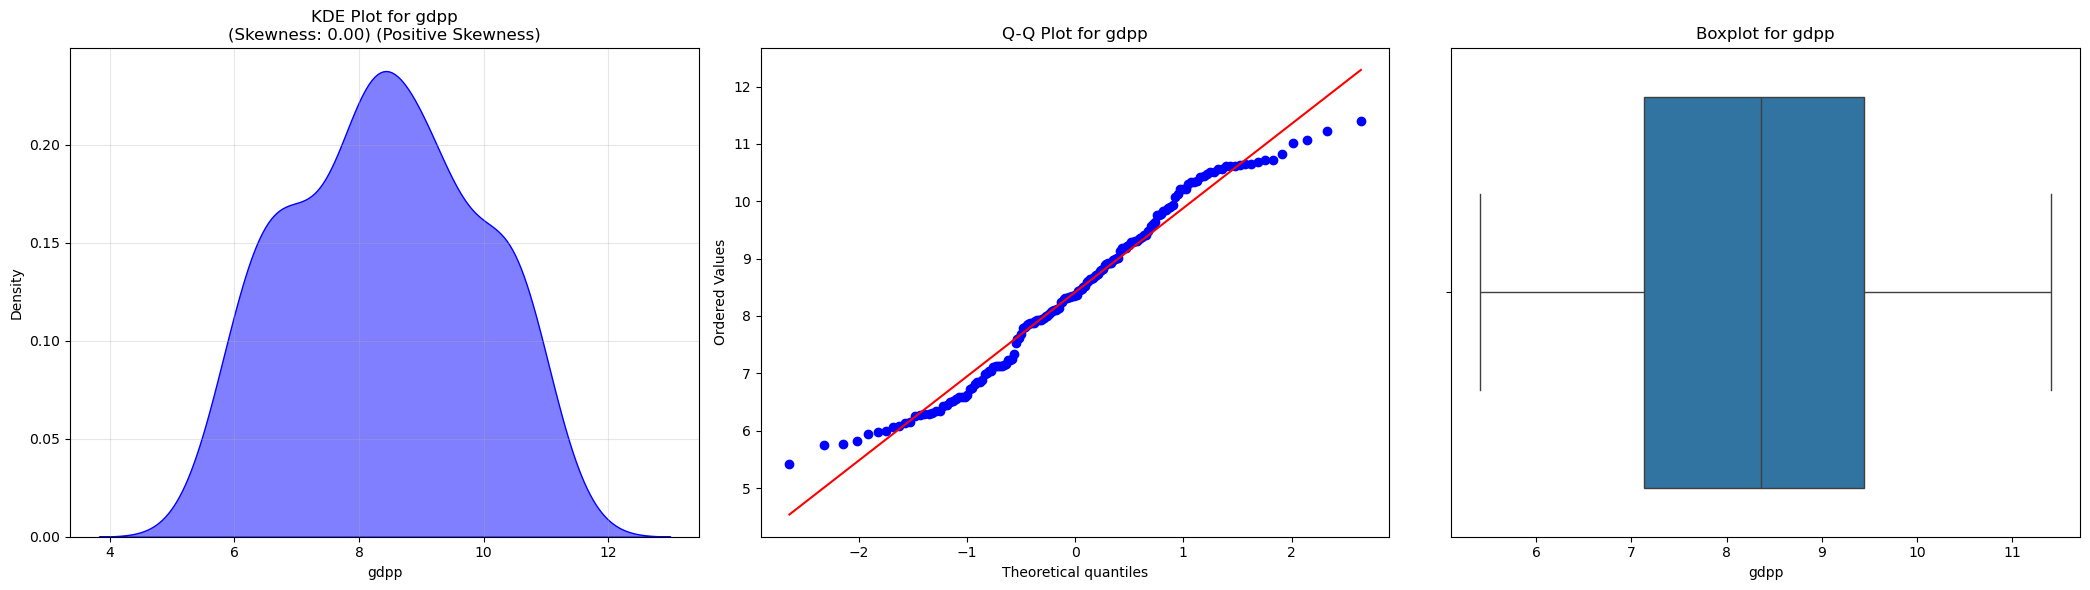

In [61]:
All_plot(X_new)

# Check optimal cluster using elbow method

In [83]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"  # Adjust the number based on your CPU cores
os.environ["OMP_NUM_THREADS"] = "1"     # Fix the MKL memory leak issue

C:\Users\parvez\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\parvez\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\parvez\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\parvez\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Wi

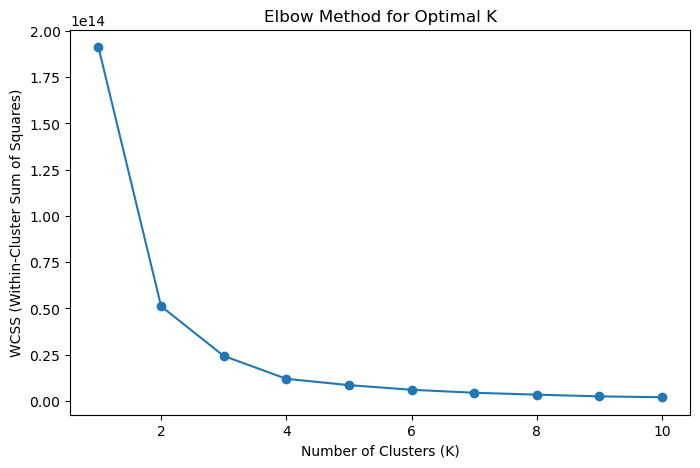

In [87]:
X_new_k = X_new.copy()
# Find the optimal number of clusters using the Elbow Method
wcss = []  # Within-cluster sum of squares
K_range = range(1, 11)  # Testing K values from 1 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init= 10)
    kmeans.fit(X_new_k)
    wcss.append(kmeans.inertia_)  # Inertia = WCSS

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal K")
plt.show()

In [192]:
from joblib import parallel_backend

X_new_clus = X_new.copy()

with parallel_backend('loky', n_jobs=1):
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    X_new_clus['cluster'] = kmeans.fit_predict(X_new_clus)

C:\Users\parvez\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [190]:
X_new_clus

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
0,4.156840,3.403266,2.810205,8.315708,10.829601,4.038811,1.091505e+06,0.886959,6.271237,1
1,2.721175,5.562585,2.599594,8.632407,14.929372,2.505919,3.390019e+06,0.637413,8.237067,0
2,3.144656,6.374882,2.012451,6.998139,15.581481,5.537502,3.423146e+06,0.765881,8.321993,0
3,4.387952,7.775477,1.590787,8.137717,13.680604,6.668443,1.399027e+06,0.894737,8.092639,1
4,2.319350,6.843588,2.484843,9.441614,16.591405,1.086089,3.473280e+06,0.698870,9.307624,0
...,...,...,...,...,...,...,...,...,...,...
162,3.202017,6.911476,2.299951,8.966259,12.113841,1.715483,1.665766e+06,0.803685,7.923155,1
163,2.746359,5.606102,2.213821,5.215218,16.210314,8.974849,3.243856e+06,0.732373,9.406678,0
164,3.009597,8.233881,2.660998,10.869334,13.050560,4.689025,2.891368e+06,0.678101,7.119279,0
165,3.760072,5.733532,2.282516,7.317446,13.045485,6.863209,2.151152e+06,0.853961,7.119279,1


In [161]:
# Evaluate clustering with Silhouette Score
silhouette_avg = silhouette_score(X_new, X_new_clus['cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.6166969525590916


# plot 2D scatterplot for plot the clusters

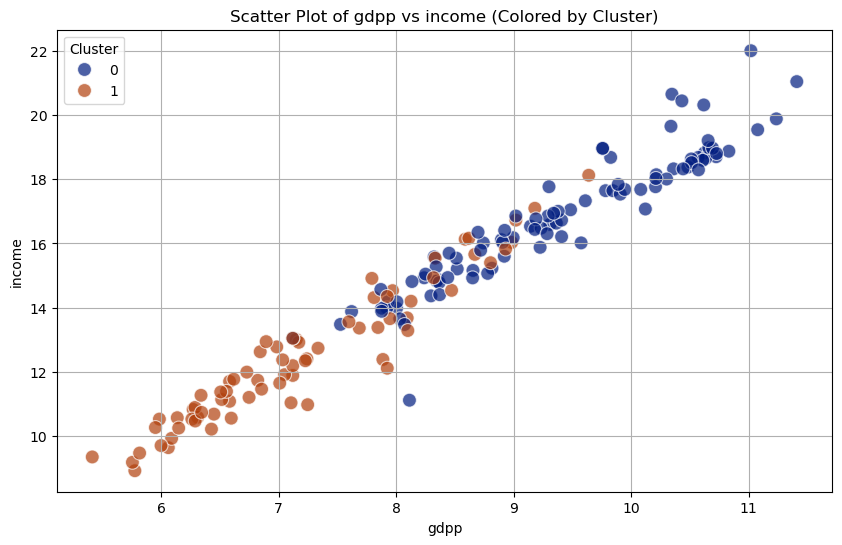

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns

# Choose two numerical columns to compare across clusters
x_col = 'gdpp'  # Replace with your desired column
y_col = 'income'  # Replace with another numerical column

# Scatter plot with clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=X_new_clus, x=x_col, y=y_col, hue='cluster', palette='dark', s=100, alpha=0.7)

# Labels and title
plt.title(f"Scatter Plot of {x_col} vs {y_col} (Colored by Cluster)")
plt.xlabel(x_col)
plt.ylabel(y_col)
plt.legend(title="Cluster")
plt.grid(True)

# Show plot
plt.show()


# plot 3D scatter plot for better visualization

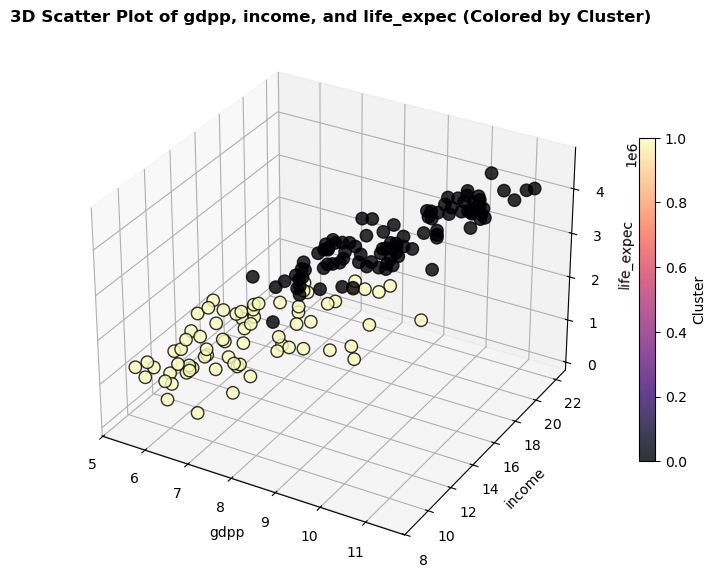

In [165]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Choose three numerical columns for 3D visualization
x_col = 'gdpp'  
y_col = 'income'  
z_col = 'life_expec'  # Replace with another numerical column

# Create figure and 3D axis
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with clusters
scatter = ax.scatter(
    X_new_clus[x_col], X_new_clus[y_col], X_new_clus[z_col], 
    c=X_new_clus['cluster'], cmap='magma', s=80, alpha=0.8, edgecolor='black'
)

# Labels and title
ax.set_title(f"3D Scatter Plot of {x_col}, {y_col}, and {z_col} (Colored by Cluster)", fontsize=12, fontweight='bold')
ax.set_xlabel(x_col, fontsize=10)
ax.set_ylabel(y_col, fontsize=10)
ax.set_zlabel(z_col, fontsize=10)

# Add legend
legend1 = plt.colorbar(scatter, ax=ax, shrink=0.6)
legend1.set_label("Cluster", fontsize=10)

# Show plot
plt.show()


# Use PCA for advance plot

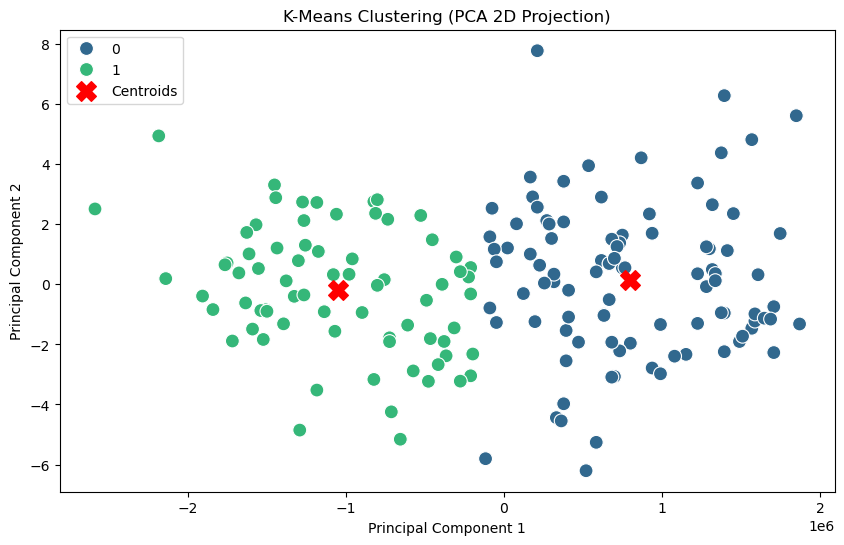

In [186]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA

# Ensure 'cluster' column is excluded before applying PCA
features = X_new_clus.drop(columns=['cluster'])

# Fit PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(features)  # Transform feature data

# Convert to DataFrame
X_pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
X_pca_df['cluster'] = X_new_clus['cluster'].values  # Add cluster labels

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=X_pca_df, x='PC1', y='PC2', hue='cluster', palette='viridis', s=100)

# Transform cluster centers using PCA (convert to DataFrame before transformation)
centroids_pca = pca.transform(pd.DataFrame(kmeans.cluster_centers_, columns=features.columns))
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='X', s=200, label='Centroids')

# Labels and title
plt.title("K-Means Clustering (PCA 2D Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()


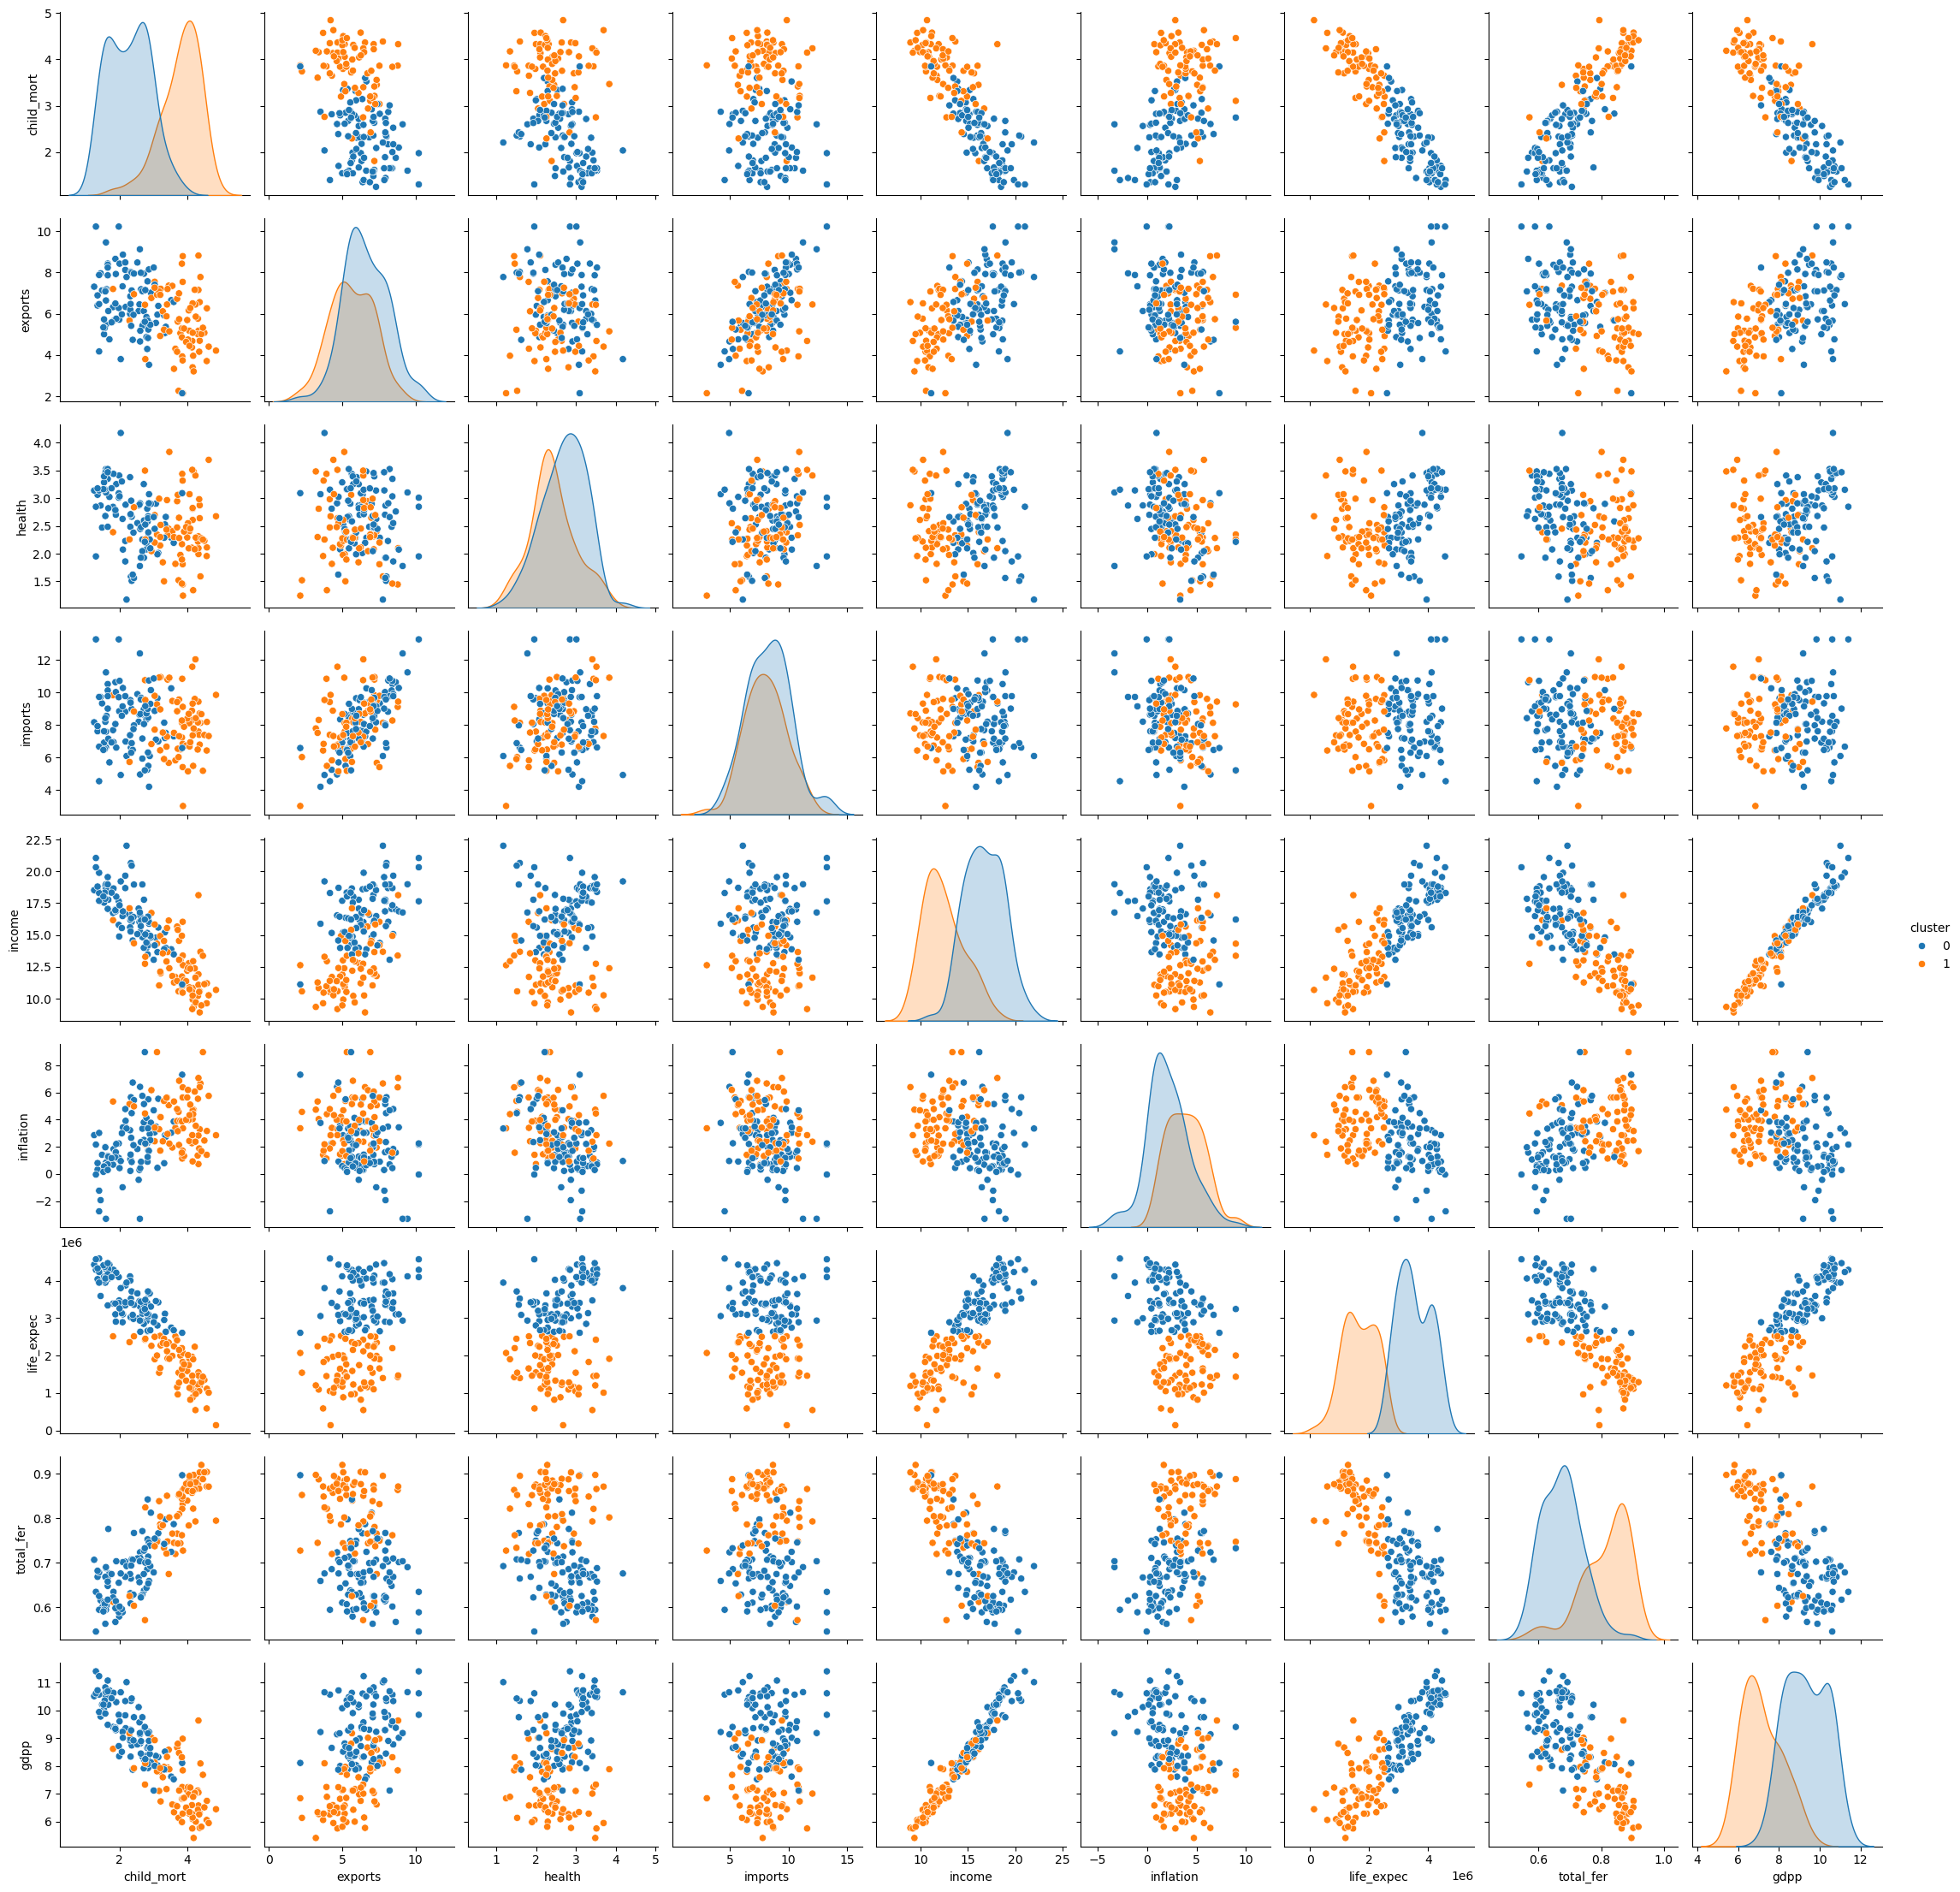

In [194]:
sns.pairplot(X_new_clus,hue="cluster")